### Modelo supervisado de identificación de crecimiento potencial en MiPyME
* Autor: Alexis Castillo
* Lenguaje: Python

In [1]:
import pandas  as pd
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from matplotlib import cycler

np.random.seed(1234)

In [160]:
%load_ext watermark

In [161]:
# Versiones librerias
%watermark --iversions

xgboost   : 1.5.0
matplotlib: 3.5.2
seaborn   : 0.11.2
numpy     : 1.21.5
pandas    : 1.4.4



In [2]:
df_universe_train = pd.read_csv('datasets/universe_train.csv')
df_universe_test = pd.read_csv('datasets/universe_test.csv')
df_acquisition = pd.read_csv('datasets/acquisition.csv')
df_balances_train = pd.read_csv('datasets/balances_train.csv')
df_balances_test = pd.read_csv('datasets/balances_test.csv')
df_legal_representatives = pd.read_csv('datasets/legal_representatives.csv')
df_movements = pd.read_csv('datasets/movements.csv')
df_taxpayer = pd.read_csv('datasets/taxpayer.csv')
df_transactionality = pd.read_csv('datasets/transactionality.csv')

In [3]:
# Cantidad de empresas por categoría (micro, pequeña, mediana)
df_universe_train.pivot_table(index = ['category'], columns = ['target'],   
                                aggfunc = {'ID':'nunique'})

ID       
target           0      1
category                 
category_1  656282  12798
category_2   41870  26123
category_3   72462    729

## Exploración dataset de balances

In [12]:
col = ['month','type','product','entity']
for i in col:
    print('================'+ i)
    print(df_balances_train[i].unique())
    print('==============================================================================')

================month
[ 1  4  2  3  8  7  6  5 11 12 10  9]
================type
['type_3' 'type_1' 'type_2' 'type_4' 'type_5']
================product
['product_3' 'product_6' 'product_1' 'product_7' 'product_4' 'product_8'
 'product_2']
================entity
['entity_1' 'entity_2' 'entity_3' 'entity_4' 'entity_5']


In [14]:
for column in col:
    print(df_balances_train.groupby(column)[column].count() / len(df_balances_train))
    print()

month
1     0.079545
2     0.080266
3     0.080852
4     0.081533
5     0.082450
6     0.083329
7     0.083632
8     0.084328
9     0.084881
10    0.085518
11    0.086413
12    0.087252
Name: month, dtype: float64

type
type_1    0.258571
type_2    0.123417
type_3    0.525042
type_4    0.082331
type_5    0.010638
Name: type, dtype: float64

product
product_1    0.094060
product_2    0.023003
product_3    0.611941
product_4    0.090775
product_6    0.151618
product_7    0.012891
product_8    0.015712
Name: product, dtype: float64

entity
entity_1    0.303377
entity_2    0.295911
entity_3    0.061180
entity_4    0.088334
entity_5    0.251198
Name: entity, dtype: float64



In [3]:
# Agrupo a nivel cliente
df_balances_train_group = pd.pivot_table(df_balances_train, 
                                  index=['ID','period','entity','type','product'], 
                                  aggfunc={
                                      'balance_amount': ['sum'],
                                      'days_default': ['sum']})
df_balances_train_group.columns = ['balance_amount','days_default']
df_balances_train_group.reset_index(inplace=True)
df_balances_train_group

,ID,period,entity,type,product,balance_amount,days_default
0,00002801de4b348d8c82af01e641b934ff20fba8814335...,period_2,entity_2,type_1,product_6,32.9441,0.0000
1,00002801de4b348d8c82af01e641b934ff20fba8814335...,period_2,entity_4,type_1,product_1,25.4235,4.0293
2,00002801de4b348d8c82af01e641b934ff20fba8814335...,period_2,entity_4,type_1,product_6,24.4816,0.0000
3,00002801de4b348d8c82af01e641b934ff20fba8814335...,period_2,entity_5,type_3,product_3,44.0144,4.7348
4,00002c940ccf2cd2bb72984737639bce8538a090c2d300...,period_1,entity_1,type_3,product_3,45.6869,0.0000
...,...,...,...,...,...,...,...
2245536,ffffd89e0574ff41ba341c7fdc908f60c5b62c42427531...,period_1,entity_1,type_3,product_3,43.3533,0.0000
2245537,ffffd89e0574ff41ba341c7fdc908f60c5b62c42427531...,period_1,entity_3,type_1,product_1,34.1109,0.0000
2245538,ffffd89e0574ff41ba341c7fdc908f60c5b62c42427531...,period_1,entity_3,type_1,product_6,28.5663,0.0000
2245539,ffffd89e0574ff41ba341c7fdc908f60c5b62c42427531...,period_1,entity_5,type_3,product_3,23.2364,1.3646


In [4]:
df_balances_prep = pd.pivot_table(df_balances_train_group, 
                                  index=['ID','period'], 
                                  columns=['entity','type','product'], 
                                  aggfunc={
                                      'balance_amount': ['sum'],
                                      'days_default': ['sum']}).fillna(0).reset_index()
df_balances_prep.columns=[x[0]+'_'+x[1]+'_'+x[2]+'_'+x[3]+'_'+x[4]
                          if x[0]!='ID' and x[0]!='period' else x[0] for x in df_balances_prep.columns]
df_balances_prep.head()

,ID,period,balance_amount_sum_entity_1_type_1_product_1,balance_amount_sum_entity_1_type_1_product_6,balance_amount_sum_entity_1_type_1_product_7,balance_amount_sum_entity_1_type_2_product_2,balance_amount_sum_entity_1_type_2_product_3,balance_amount_sum_entity_1_type_3_product_2,balance_amount_sum_entity_1_type_3_product_3,balance_amount_sum_entity_1_type_4_product_2,balance_amount_sum_entity_1_type_4_product_3,balance_amount_sum_entity_1_type_4_product_4,balance_amount_sum_entity_1_type_5_product_3,balance_amount_sum_entity_1_type_5_product_8,balance_amount_sum_entity_2_type_1_product_1,balance_amount_sum_entity_2_type_1_product_6,balance_amount_sum_entity_2_type_1_product_7,balance_amount_sum_entity_2_type_2_product_2,balance_amount_sum_entity_2_type_2_product_3,balance_amount_sum_entity_2_type_2_product_4,balance_amount_sum_entity_2_type_2_product_8,balance_amount_sum_entity_2_type_3_product_2,balance_amount_sum_entity_2_type_3_product_3,balance_amount_sum_entity_2_type_3_product_4,balance_amount_sum_entity_2_type_3_product_8,balance_amount_sum_entity_2_type_4_product_2,balance_amount_sum_entity_2_type_4_product_3,balance_amount_sum_entity_2_type_4_product_4,balance_amount_sum_entity_2_type_4_product_8,balance_amount_sum_entity_2_type_5_product_2,balance_amount_sum_entity_2_type_5_product_3,balance_amount_sum_entity_2_type_5_product_4,balance_amount_sum_entity_2_type_5_product_8,balance_amount_sum_entity_3_type_1_product_1,balance_amount_sum_entity_3_type_1_product_2,balance_amount_sum_entity_3_type_1_product_6,balance_amount_sum_entity_3_type_1_product_7,balance_amount_sum_entity_3_type_2_product_2,balance_amount_sum_entity_3_type_2_product_3,balance_amount_sum_entity_3_type_2_product_4,balance_amount_sum_entity_3_type_2_product_8,balance_amount_sum_entity_3_type_3_product_2,balance_amount_sum_entity_3_type_3_product_3,balance_amount_sum_entity_3_type_3_product_4,balance_amount_sum_entity_3_type_3_product_8,balance_amount_sum_entity_3_type_4_product_2,balance_amount_sum_entity_3_type_4_product_3,balance_amount_sum_entity_3_type_4_product_4,balance_amount_sum_entity_3_type_4_product_8,balance_amount_sum_entity_3_type_5_product_3,balance_amount_sum_entity_3_type_5_product_8,balance_amount_sum_entity_4_type_1_product_1,balance_amount_sum_entity_4_type_1_product_6,balance_amount_sum_entity_4_type_1_product_7,balance_amount_sum_entity_4_type_2_product_2,balance_amount_sum_entity_4_type_2_product_3,balance_amount_sum_entity_4_type_2_product_4,balance_amount_sum_entity_4_type_2_product_8,balance_amount_sum_entity_4_type_3_product_2,balance_amount_sum_entity_4_type_3_product_3,balance_amount_sum_entity_4_type_3_product_4,balance_amount_sum_entity_4_type_3_product_8,balance_amount_sum_entity_4_type_4_product_2,balance_amount_sum_entity_4_type_4_product_3,balance_amount_sum_entity_4_type_4_product_4,balance_amount_sum_entity_4_type_4_product_8,balance_amount_sum_entity_4_type_5_product_2,balance_amount_sum_entity_4_type_5_product_3,balance_amount_sum_entity_4_type_5_product_8,balance_amount_sum_entity_5_type_1_product_1,balance_amount_sum_entity_5_type_1_product_6,balance_amount_sum_entity_5_type_1_product_7,balance_amount_sum_entity_5_type_2_product_2,balance_amount_sum_entity_5_type_2_product_3,balance_amount_sum_entity_5_type_2_product_8,balance_amount_sum_entity_5_type_3_product_2,balance_amount_sum_entity_5_type_3_product_3,balance_amount_sum_entity_5_type_3_product_8,balance_amount_sum_entity_5_type_4_product_2,balance_amount_sum_entity_5_type_4_product_3,balance_amount_sum_entity_5_type_4_product_8,balance_amount_sum_entity_5_type_5_product_8,days_default_sum_entity_1_type_1_product_1,days_default_sum_entity_1_type_1_product_6,days_default_sum_entity_1_type_1_product_7,days_default_sum_entity_1_type_2_product_2,days_default_sum_entity_1_type_2_product_3,days_default_sum_entity_1_type_3_product_2,days_default_sum_entity_1_type_3_product_3,days_default_sum_entity_1_type_4_product_2,days_default_sum_entity_1_type_4_product_3,da

In [5]:
# Escalamos variables
from sklearn.preprocessing import MinMaxScaler
sc_X = MinMaxScaler()                       
df_balances_prep_scale = sc_X.fit_transform(df_balances_prep.drop(['ID','period'], axis=1))          

In [6]:
df_balances_prep = pd.concat([df_balances_prep[['ID','period']], pd.DataFrame(df_balances_prep_scale, 
                                                                   columns=list(df_balances_prep.drop(['ID','period'], axis=1).columns))], 
                             axis=1)

In [23]:
df_balances_prep.shape

(809846, 162)

In [7]:
df_balances_train['month'] = df_balances_train.month.astype(str)

In [8]:
df_balances_prep_1 = pd.pivot_table(df_balances_train, 
                                  index=['ID','period'], 
                                  columns=['month','entity','type','product'], 
                                  aggfunc={
                                      'balance_amount': ['sum'],
                                      'days_default': ['sum']}).fillna(0).reset_index()
df_balances_prep_1.columns=[x[0]+'_'+x[1]+'_'+x[2]+'_'+x[3]+'_'+x[4]+'_'+x[5]
                          if x[0]!='ID' and x[0]!='period' else x[0] for x in df_balances_prep_1.columns]
df_balances_prep_1.head()

,ID,period,balance_amount_sum_1_entity_1_type_1_product_1,balance_amount_sum_1_entity_1_type_1_product_6,balance_amount_sum_1_entity_1_type_1_product_7,balance_amount_sum_1_entity_1_type_2_product_2,balance_amount_sum_1_entity_1_type_2_product_3,balance_amount_sum_1_entity_1_type_3_product_2,balance_amount_sum_1_entity_1_type_3_product_3,balance_amount_sum_1_entity_1_type_4_product_2,balance_amount_sum_1_entity_1_type_4_product_3,balance_amount_sum_1_entity_1_type_4_product_4,balance_amount_sum_1_entity_1_type_5_product_3,balance_amount_sum_1_entity_1_type_5_product_8,balance_amount_sum_1_entity_2_type_1_product_1,balance_amount_sum_1_entity_2_type_1_product_6,balance_amount_sum_1_entity_2_type_1_product_7,balance_amount_sum_1_entity_2_type_2_product_2,balance_amount_sum_1_entity_2_type_2_product_3,balance_amount_sum_1_entity_2_type_2_product_4,balance_amount_sum_1_entity_2_type_2_product_8,balance_amount_sum_1_entity_2_type_3_product_2,balance_amount_sum_1_entity_2_type_3_product_3,balance_amount_sum_1_entity_2_type_3_product_4,balance_amount_sum_1_entity_2_type_3_product_8,balance_amount_sum_1_entity_2_type_4_product_2,balance_amount_sum_1_entity_2_type_4_product_3,balance_amount_sum_1_entity_2_type_4_product_4,balance_amount_sum_1_entity_2_type_4_product_8,balance_amount_sum_1_entity_2_type_5_product_2,balance_amount_sum_1_entity_2_type_5_product_3,balance_amount_sum_1_entity_2_type_5_product_4,balance_amount_sum_1_entity_2_type_5_product_8,balance_amount_sum_1_entity_3_type_1_product_1,balance_amount_sum_1_entity_3_type_1_product_2,balance_amount_sum_1_entity_3_type_1_product_6,balance_amount_sum_1_entity_3_type_1_product_7,balance_amount_sum_1_entity_3_type_2_product_2,balance_amount_sum_1_entity_3_type_2_product_3,balance_amount_sum_1_entity_3_type_2_product_4,balance_amount_sum_1_entity_3_type_2_product_8,balance_amount_sum_1_entity_3_type_3_product_2,balance_amount_sum_1_entity_3_type_3_product_3,balance_amount_sum_1_entity_3_type_3_product_4,balance_amount_sum_1_entity_3_type_3_product_8,balance_amount_sum_1_entity_3_type_4_product_2,balance_amount_sum_1_entity_3_type_4_product_3,balance_amount_sum_1_entity_3_type_4_product_4,balance_amount_sum_1_entity_3_type_4_product_8,balance_amount_sum_1_entity_3_type_5_product_3,balance_amount_sum_1_entity_3_type_5_product_8,balance_amount_sum_1_entity_4_type_1_product_1,balance_amount_sum_1_entity_4_type_1_product_6,balance_amount_sum_1_entity_4_type_1_product_7,balance_amount_sum_1_entity_4_type_2_product_2,balance_amount_sum_1_entity_4_type_2_product_3,balance_amount_sum_1_entity_4_type_2_product_4,balance_amount_sum_1_entity_4_type_2_product_8,balance_amount_sum_1_entity_4_type_3_product_2,balance_amount_sum_1_entity_4_type_3_product_3,balance_amount_sum_1_entity_4_type_3_product_4,balance_amount_sum_1_entity_4_type_3_product_8,balance_amount_sum_1_entity_4_type_4_product_2,balance_amount_sum_1_entity_4_type_4_product_3,balance_amount_sum_1_entity_4_type_4_product_4,balance_amount_sum_1_entity_4_type_4_product_8,balance_amount_sum_1_entity_4_type_5_product_2,balance_amount_sum_1_entity_4_type_5_product_3,balance_amount_sum_1_entity_4_type_5_product_8,balance_amount_sum_1_entity_5_type_1_product_1,balance_amount_sum_1_entity_5_type_1_product_6,balance_amount_sum_1_entity_5_type_1_product_7,balance_amount_sum_1_entity_5_type_2_product_2,balance_amount_sum_1_entity_5_type_2_product_3,balance_amount_sum_1_entity_5_type_3_product_2,balance_amount_sum_1_entity_5_type_3_product_3,balance_amount_sum_1_entity_5_type_3_product_8,balance_amount_sum_1_entity_5_type_4_product_2,balance_amount_sum_1_entity_5_type_4_product_3,balance_amount_sum_1_entity_5_type_4_product_8,balance_amount_sum_1_entity_5_type_5_product_8,balance_amount_sum_10_entity_1_type_1_product_1,balance_amount_sum_10_entity_1_type_1_product_6,balance_amount_sum_10_entity_1_type_1_product_7,balance_amount_sum_10_entity_1_type_2_product_2,balance_amount_sum_10_entity_1_type_2_product_3,balance_amount_sum_10_entity_1_type_

In [9]:
# Cruce bases
df_info_empresas = df_universe_train.merge(
    df_taxpayer, on=['ID','period'], how='left').merge(
    df_movements, on=['ID','period'], how='left').merge(
    df_acquisition, on=['ID','period'], how='left').merge(
    df_transactionality, on=['ID','period'], how='left').merge(
    df_balances_prep, on=['ID','period'], how='left').fillna(0)

In [10]:
# Cruce bases para categoria 2
df_info_empresas_1 = df_universe_train.merge(
    df_taxpayer, on=['ID','period'], how='left').merge(
    df_movements, on=['ID','period'], how='left').merge(
    df_acquisition, on=['ID','period'], how='left').merge(
    df_transactionality, on=['ID','period'], how='left').merge(
    df_balances_prep_1, on=['ID','period'], how='left').fillna(0)

In [11]:
# Separando variables categóricas y numéricas
ColumnsCategoricas = ['activity','economic_category','road','license']

In [12]:
# Encoding de variables
df_info_empresas_cat = pd.get_dummies(df_info_empresas[ColumnsCategoricas], drop_first=True)
df_info_empresas_cat.head()

,activity_activity_10,activity_activity_11,activity_activity_12,activity_activity_2,activity_activity_3,activity_activity_4,activity_activity_5,activity_activity_6,activity_activity_7,activity_activity_8,activity_activity_9,economic_category_category_10,economic_category_category_11,economic_category_category_12,economic_category_category_13,economic_category_category_14,economic_category_category_15,economic_category_category_16,economic_category_category_17,economic_category_category_18,economic_category_category_19,economic_category_category_2,economic_category_category_20,economic_category_category_21,economic_category_category_22,economic_category_category_23,economic_category_category_24,economic_category_category_25,economic_category_category_26,economic_category_category_27,economic_category_category_28,economic_category_category_29,economic_category_category_3,economic_category_category_30,economic_category_category_31,economic_category_category_32,economic_category_category_33,economic_category_category_34,economic_category_category_35,economic_category_category_36,economic_category_category_37,economic_category_category_38,economic_category_category_39,economic_category_category_4,economic_category_category_40,economic_category_category_41,economic_category_category_42,economic_category_category_43,economic_category_category_44,economic_category_category_45,economic_category_category_5,economic_category_category_6,economic_category_category_7,economic_category_category_9,road_road_2,road_road_3,road_road_4,road_road_5,road_road_6,road_road_7,license_yes
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [13]:
df_info_empresas_2 = pd.concat([df_info_empresas.drop(ColumnsCategoricas, axis=1), 
                               df_info_empresas_cat], axis=1)

In [14]:
df_info_empresas_2.head()

,ID,category,target,period,time_from_start,establishments,amount,transactions,customers,number_credit_acquisitions,total_amount,max_amount,min_amount,cashIn_amount,cashIn_trx,cashOut_amount,cashOut_trx,balance_amount_sum_entity_1_type_1_product_1,balance_amount_sum_entity_1_type_1_product_6,balance_amount_sum_entity_1_type_1_product_7,balance_amount_sum_entity_1_type_2_product_2,balance_amount_sum_entity_1_type_2_product_3,balance_amount_sum_entity_1_type_3_product_2,balance_amount_sum_entity_1_type_3_product_3,balance_amount_sum_entity_1_type_4_product_2,balance_amount_sum_entity_1_type_4_product_3,balance_amount_sum_entity_1_type_4_product_4,balance_amount_sum_entity_1_type_5_product_3,balance_amount_sum_entity_1_type_5_product_8,balance_amount_sum_entity_2_type_1_product_1,balance_amount_sum_entity_2_type_1_product_6,balance_amount_sum_entity_2_type_1_product_7,balance_amount_sum_entity_2_type_2_product_2,balance_amount_sum_entity_2_type_2_product_3,balance_amount_sum_entity_2_type_2_product_4,balance_amount_sum_entity_2_type_2_product_8,balance_amount_sum_entity_2_type_3_product_2,balance_amount_sum_entity_2_type_3_product_3,balance_amount_sum_entity_2_type_3_product_4,balance_amount_sum_entity_2_type_3_product_8,balance_amount_sum_entity_2_type_4_product_2,balance_amount_sum_entity_2_type_4_product_3,balance_amount_sum_entity_2_type_4_product_4,balance_amount_sum_entity_2_type_4_product_8,balance_amount_sum_entity_2_type_5_product_2,balance_amount_sum_entity_2_type_5_product_3,balance_amount_sum_entity_2_type_5_product_4,balance_amount_sum_entity_2_type_5_product_8,balance_amount_sum_entity_3_type_1_product_1,balance_amount_sum_entity_3_type_1_product_2,balance_amount_sum_entity_3_type_1_product_6,balance_amount_sum_entity_3_type_1_product_7,balance_amount_sum_entity_3_type_2_product_2,balance_amount_sum_entity_3_type_2_product_3,balance_amount_sum_entity_3_type_2_product_4,balance_amount_sum_entity_3_type_2_product_8,balance_amount_sum_entity_3_type_3_product_2,balance_amount_sum_entity_3_type_3_product_3,balance_amount_sum_entity_3_type_3_product_4,balance_amount_sum_entity_3_type_3_product_8,balance_amount_sum_entity_3_type_4_product_2,balance_amount_sum_entity_3_type_4_product_3,balance_amount_sum_entity_3_type_4_product_4,balance_amount_sum_entity_3_type_4_product_8,balance_amount_sum_entity_3_type_5_product_3,balance_amount_sum_entity_3_type_5_product_8,balance_amount_sum_entity_4_type_1_product_1,balance_amount_sum_entity_4_type_1_product_6,balance_amount_sum_entity_4_type_1_product_7,balance_amount_sum_entity_4_type_2_product_2,balance_amount_sum_entity_4_type_2_product_3,balance_amount_sum_entity_4_type_2_product_4,balance_amount_sum_entity_4_type_2_product_8,balance_amount_sum_entity_4_type_3_product_2,balance_amount_sum_entity_4_type_3_product_3,balance_amount_sum_entity_4_type_3_product_4,balance_amount_sum_entity_4_type_3_product_8,balance_amount_sum_entity_4_type_4_product_2,balance_amount_sum_entity_4_type_4_product_3,balance_amount_sum_entity_4_type_4_product_4,balance_amount_sum_entity_4_type_4_product_8,balance_amount_sum_entity_4_type_5_product_2,balance_amount_sum_entity_4_type_5_product_3,balance_amount_sum_entity_4_type_5_product_8,balance_amount_sum_entity_5_type_1_product_1,balance_amount_sum_entity_5_type_1_product_6,balance_amount_sum_entity_5_type_1_product_7,balance_amount_sum_entity_5_type_2_product_2,balance_amount_sum_entity_5_type_2_product_3,balance_amount_sum_entity_5_type_2_product_8,balance_amount_sum_entity_5_type_3_product_2,balance_amount_sum_entity_5_type_3_product_3,balance_amount_sum_entity_5_type_3_product_8,balance_amount_sum_entity_5_type_4_product_2,balance_amount_sum_entity_5_type_4_product_3,balance_amount_sum_entity_5_type_4_product_8,balance_amount_sum_entity_5_type_5_product_8,days_default_sum_entity_1_type_1_product_1,days_default_sum_entity_1_type_1_product_6,days_default_sum_entity_1_type_1_product_7,days_default_sum_entity_1_type_2_product_2,days_default_sum_entity_1_

In [14]:
# Encoding de variables
df_info_empresas_cat_1 = pd.get_dummies(df_info_empresas_1[ColumnsCategoricas], drop_first=True)
df_info_empresas_cat_1.head()

,activity_activity_10,activity_activity_11,activity_activity_12,activity_activity_2,activity_activity_3,activity_activity_4,activity_activity_5,activity_activity_6,activity_activity_7,activity_activity_8,activity_activity_9,economic_category_category_10,economic_category_category_11,economic_category_category_12,economic_category_category_13,economic_category_category_14,economic_category_category_15,economic_category_category_16,economic_category_category_17,economic_category_category_18,economic_category_category_19,economic_category_category_2,economic_category_category_20,economic_category_category_21,economic_category_category_22,economic_category_category_23,economic_category_category_24,economic_category_category_25,economic_category_category_26,economic_category_category_27,economic_category_category_28,economic_category_category_29,economic_category_category_3,economic_category_category_30,economic_category_category_31,economic_category_category_32,economic_category_category_33,economic_category_category_34,economic_category_category_35,economic_category_category_36,economic_category_category_37,economic_category_category_38,economic_category_category_39,economic_category_category_4,economic_category_category_40,economic_category_category_41,economic_category_category_42,economic_category_category_43,economic_category_category_44,economic_category_category_45,economic_category_category_5,economic_category_category_6,economic_category_category_7,economic_category_category_9,road_road_2,road_road_3,road_road_4,road_road_5,road_road_6,road_road_7,license_yes
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [15]:
df_info_empresas_2_1 = pd.concat([df_info_empresas_1.drop(ColumnsCategoricas, axis=1), 
                               df_info_empresas_cat_1], axis=1)

In [31]:
df_info_empresas_2_1.head()

,ID,category,target,period,time_from_start,establishments,amount,transactions,customers,number_credit_acquisitions,total_amount,max_amount,min_amount,cashIn_amount,cashIn_trx,cashOut_amount,cashOut_trx,balance_amount_sum_1_entity_1_type_1_product_1,balance_amount_sum_1_entity_1_type_1_product_6,balance_amount_sum_1_entity_1_type_1_product_7,balance_amount_sum_1_entity_1_type_2_product_2,balance_amount_sum_1_entity_1_type_2_product_3,balance_amount_sum_1_entity_1_type_3_product_2,balance_amount_sum_1_entity_1_type_3_product_3,balance_amount_sum_1_entity_1_type_4_product_2,balance_amount_sum_1_entity_1_type_4_product_3,balance_amount_sum_1_entity_1_type_4_product_4,balance_amount_sum_1_entity_1_type_5_product_3,balance_amount_sum_1_entity_1_type_5_product_8,balance_amount_sum_1_entity_2_type_1_product_1,balance_amount_sum_1_entity_2_type_1_product_6,balance_amount_sum_1_entity_2_type_1_product_7,balance_amount_sum_1_entity_2_type_2_product_2,balance_amount_sum_1_entity_2_type_2_product_3,balance_amount_sum_1_entity_2_type_2_product_4,balance_amount_sum_1_entity_2_type_2_product_8,balance_amount_sum_1_entity_2_type_3_product_2,balance_amount_sum_1_entity_2_type_3_product_3,balance_amount_sum_1_entity_2_type_3_product_4,balance_amount_sum_1_entity_2_type_3_product_8,balance_amount_sum_1_entity_2_type_4_product_2,balance_amount_sum_1_entity_2_type_4_product_3,balance_amount_sum_1_entity_2_type_4_product_4,balance_amount_sum_1_entity_2_type_4_product_8,balance_amount_sum_1_entity_2_type_5_product_2,balance_amount_sum_1_entity_2_type_5_product_3,balance_amount_sum_1_entity_2_type_5_product_4,balance_amount_sum_1_entity_2_type_5_product_8,balance_amount_sum_1_entity_3_type_1_product_1,balance_amount_sum_1_entity_3_type_1_product_2,balance_amount_sum_1_entity_3_type_1_product_6,balance_amount_sum_1_entity_3_type_1_product_7,balance_amount_sum_1_entity_3_type_2_product_2,balance_amount_sum_1_entity_3_type_2_product_3,balance_amount_sum_1_entity_3_type_2_product_4,balance_amount_sum_1_entity_3_type_2_product_8,balance_amount_sum_1_entity_3_type_3_product_2,balance_amount_sum_1_entity_3_type_3_product_3,balance_amount_sum_1_entity_3_type_3_product_4,balance_amount_sum_1_entity_3_type_3_product_8,balance_amount_sum_1_entity_3_type_4_product_2,balance_amount_sum_1_entity_3_type_4_product_3,balance_amount_sum_1_entity_3_type_4_product_4,balance_amount_sum_1_entity_3_type_4_product_8,balance_amount_sum_1_entity_3_type_5_product_3,balance_amount_sum_1_entity_3_type_5_product_8,balance_amount_sum_1_entity_4_type_1_product_1,balance_amount_sum_1_entity_4_type_1_product_6,balance_amount_sum_1_entity_4_type_1_product_7,balance_amount_sum_1_entity_4_type_2_product_2,balance_amount_sum_1_entity_4_type_2_product_3,balance_amount_sum_1_entity_4_type_2_product_4,balance_amount_sum_1_entity_4_type_2_product_8,balance_amount_sum_1_entity_4_type_3_product_2,balance_amount_sum_1_entity_4_type_3_product_3,balance_amount_sum_1_entity_4_type_3_product_4,balance_amount_sum_1_entity_4_type_3_product_8,balance_amount_sum_1_entity_4_type_4_product_2,balance_amount_sum_1_entity_4_type_4_product_3,balance_amount_sum_1_entity_4_type_4_product_4,balance_amount_sum_1_entity_4_type_4_product_8,balance_amount_sum_1_entity_4_type_5_product_2,balance_amount_sum_1_entity_4_type_5_product_3,balance_amount_sum_1_entity_4_type_5_product_8,balance_amount_sum_1_entity_5_type_1_product_1,balance_amount_sum_1_entity_5_type_1_product_6,balance_amount_sum_1_entity_5_type_1_product_7,balance_amount_sum_1_entity_5_type_2_product_2,balance_amount_sum_1_entity_5_type_2_product_3,balance_amount_sum_1_entity_5_type_3_product_2,balance_amount_sum_1_entity_5_type_3_product_3,balance_amount_sum_1_entity_5_type_3_product_8,balance_amount_sum_1_entity_5_type_4_product_2,balance_amount_sum_1_entity_5_type_4_product_3,balance_amount_sum_1_entity_5_type_4_product_8,balance_amount_sum_1_entity_5_type_5_product_8,balance_amount_sum_10_entity_1_type_1_product_1,balance_amount_sum_10_entity_1_type_1

### Procesamiento data de Test

In [ ]:
# Agrupo a nivel cliente
df_balances_test_group = pd.pivot_table(df_balances_test, 
                                  index=['ID','period','entity','type','product'], 
                                  aggfunc={
                                      'balance_amount': ['sum'],
                                      'days_default': ['sum']})
df_balances_test_group.columns = ['balance_amount','days_default']
df_balances_test_group.reset_index(inplace=True)

df_balances_prep_test = pd.pivot_table(df_balances_test_group, 
                                  index=['ID','period'], 
                                  columns=['entity','type','product'], 
                                  aggfunc={
                                      'balance_amount': ['sum'],
                                      'days_default': ['sum']}).fillna(0).reset_index()
df_balances_prep_test.columns=[x[0]+'_'+x[1]+'_'+x[2]+'_'+x[3]+'_'+x[4]
                          if x[0]!='ID' and x[0]!='period' else x[0] for x in df_balances_prep_test.columns]

df_balances_test['month'] = df_balances_test.month.astype(str)

df_balances_prep_test_1 = pd.pivot_table(df_balances_test, 
                                  index=['ID','period'], 
                                  columns=['month','entity','type','product'], 
                                  aggfunc={
                                      'balance_amount': ['sum'],
                                      'days_default': ['sum']}).fillna(0).reset_index()
df_balances_prep_test_1.columns=[x[0]+'_'+x[1]+'_'+x[2]+'_'+x[3]+'_'+x[4]+'_'+x[5]
                          if x[0]!='ID' and x[0]!='period' else x[0] for x in df_balances_prep_test_1.columns]

sc_X_test = MinMaxScaler()                       
df_balances_prep_test_scale = sc_X_test.fit_transform(df_balances_prep_test.drop(['ID','period'], axis=1))    
df_balances_prep_test = pd.concat([df_balances_prep_test[['ID','period']], pd.DataFrame(df_balances_prep_test_scale, 
                                                                   columns=list(df_balances_prep_test.drop(['ID','period'], 
                                                                                                           axis=1).columns))], 
                             axis=1)

# Cruzo universe, balances
df_info_empresas_test = df_universe_test.merge(
    df_taxpayer, on=['ID','period'], how='left').merge(
    df_movements, on=['ID','period'], how='left').merge(
    df_acquisition, on=['ID','period'], how='left').merge(
    df_transactionality, on=['ID','period'], how='left').merge(
    df_balances_prep_test, on=['ID','period'], how='left').fillna(0)

# Cruzo universe, balances para categoria 2
df_info_empresas_test_1 = df_universe_test.merge(
    df_taxpayer, on=['ID','period'], how='left').merge(
    df_movements, on=['ID','period'], how='left').merge(
    df_acquisition, on=['ID','period'], how='left').merge(
    df_transactionality, on=['ID','period'], how='left').merge(
    df_balances_prep_test_1, on=['ID','period'], how='left').fillna(0)

# Separando variables categóricas y numéricas
ColumnsCategoricas = ['activity','economic_category','road','license']

# Encoding de variables
df_info_empresas_cat_test = pd.get_dummies(df_info_empresas_test[ColumnsCategoricas], drop_first=True)

# Encoding de variables
df_info_empresas_cat_test_1 = pd.get_dummies(df_info_empresas_test_1[ColumnsCategoricas], drop_first=True)

df_info_empresas_cat_test.drop('economic_category_category_8', axis=1, inplace=True)
df_info_empresas_cat_test_1.drop('economic_category_category_8', axis=1, inplace=True)

df_info_empresas_test_2 = pd.concat([df_info_empresas_test.drop(ColumnsCategoricas, axis=1), 
                               df_info_empresas_cat_test], axis=1)

df_info_empresas_test_2_1 = pd.concat([df_info_empresas_test_1.drop(ColumnsCategoricas, axis=1), 
                               df_info_empresas_cat_test], axis=1)

In [29]:
# Eliminar variables que no están presentes en set de test
list_train_2 = list(df_info_empresas_2.columns)
list_test_2 = list(df_info_empresas_test_2.columns)

vars_add_test_2 = [x for x in list_train_2 if x not in list_test_2]
vars_add_test_2

df_info_empresas_2.drop(vars_add_test_2[1:], axis=1, inplace=True)

In [30]:
list_train_2_1 = list(df_info_empresas_2_1.columns)
list_test_2_1 = list(df_info_empresas_test_2_1.columns)

vars_add_test_2_1 = [x for x in list_train_2_1 if x not in list_test_2_1]

df_info_empresas_2_1.drop(vars_add_test_2_1[1:], axis=1, inplace=True)

In [31]:
df_info_empresas_2

,ID,category,target,period,time_from_start,establishments,amount,transactions,customers,number_credit_acquisitions,total_amount,max_amount,min_amount,cashIn_amount,cashIn_trx,cashOut_amount,cashOut_trx,balance_amount_sum_entity_1_type_1_product_1,balance_amount_sum_entity_1_type_1_product_6,balance_amount_sum_entity_1_type_1_product_7,balance_amount_sum_entity_1_type_2_product_2,balance_amount_sum_entity_1_type_2_product_3,balance_amount_sum_entity_1_type_3_product_2,balance_amount_sum_entity_1_type_3_product_3,balance_amount_sum_entity_1_type_4_product_2,balance_amount_sum_entity_1_type_4_product_3,balance_amount_sum_entity_1_type_4_product_4,balance_amount_sum_entity_1_type_5_product_8,balance_amount_sum_entity_2_type_1_product_1,balance_amount_sum_entity_2_type_1_product_6,balance_amount_sum_entity_2_type_1_product_7,balance_amount_sum_entity_2_type_2_product_2,balance_amount_sum_entity_2_type_2_product_3,balance_amount_sum_entity_2_type_2_product_4,balance_amount_sum_entity_2_type_2_product_8,balance_amount_sum_entity_2_type_3_product_2,balance_amount_sum_entity_2_type_3_product_3,balance_amount_sum_entity_2_type_3_product_4,balance_amount_sum_entity_2_type_3_product_8,balance_amount_sum_entity_2_type_4_product_2,balance_amount_sum_entity_2_type_4_product_3,balance_amount_sum_entity_2_type_4_product_4,balance_amount_sum_entity_2_type_4_product_8,balance_amount_sum_entity_2_type_5_product_2,balance_amount_sum_entity_2_type_5_product_3,balance_amount_sum_entity_2_type_5_product_8,balance_amount_sum_entity_3_type_1_product_1,balance_amount_sum_entity_3_type_1_product_6,balance_amount_sum_entity_3_type_1_product_7,balance_amount_sum_entity_3_type_2_product_2,balance_amount_sum_entity_3_type_2_product_3,balance_amount_sum_entity_3_type_2_product_4,balance_amount_sum_entity_3_type_2_product_8,balance_amount_sum_entity_3_type_3_product_2,balance_amount_sum_entity_3_type_3_product_3,balance_amount_sum_entity_3_type_3_product_4,balance_amount_sum_entity_3_type_3_product_8,balance_amount_sum_entity_3_type_4_product_2,balance_amount_sum_entity_3_type_4_product_3,balance_amount_sum_entity_3_type_4_product_4,balance_amount_sum_entity_3_type_4_product_8,balance_amount_sum_entity_3_type_5_product_8,balance_amount_sum_entity_4_type_1_product_1,balance_amount_sum_entity_4_type_1_product_6,balance_amount_sum_entity_4_type_1_product_7,balance_amount_sum_entity_4_type_2_product_2,balance_amount_sum_entity_4_type_2_product_3,balance_amount_sum_entity_4_type_2_product_4,balance_amount_sum_entity_4_type_2_product_8,balance_amount_sum_entity_4_type_3_product_2,balance_amount_sum_entity_4_type_3_product_3,balance_amount_sum_entity_4_type_3_product_4,balance_amount_sum_entity_4_type_3_product_8,balance_amount_sum_entity_4_type_4_product_2,balance_amount_sum_entity_4_type_4_product_3,balance_amount_sum_entity_4_type_4_product_4,balance_amount_sum_entity_4_type_4_product_8,balance_amount_sum_entity_4_type_5_product_2,balance_amount_sum_entity_4_type_5_product_3,balance_amount_sum_entity_4_type_5_product_8,balance_amount_sum_entity_5_type_1_product_1,balance_amount_sum_entity_5_type_1_product_6,balance_amount_sum_entity_5_type_1_product_7,balance_amount_sum_entity_5_type_2_product_2,balance_amount_sum_entity_5_type_2_product_3,balance_amount_sum_entity_5_type_2_product_8,balance_amount_sum_entity_5_type_3_product_2,balance_amount_sum_entity_5_type_3_product_3,balance_amount_sum_entity_5_type_3_product_8,balance_amount_sum_entity_5_type_4_product_2,balance_amount_sum_entity_5_type_4_product_3,balance_amount_sum_entity_5_type_4_product_8,balance_amount_sum_entity_5_type_5_product_8,days_default_sum_entity_1_type_1_product_1,days_default_sum_entity_1_type_1_product_6,days_default_sum_entity_1_type_1_product_7,days_default_sum_entity_1_type_2_product_2,days_default_sum_entity_1_type_2_product_3,days_default_sum_entity_1_type_3_product_2,days_default_sum_entity_1_type_3_product_3,days_default_sum_entity_1_type_4_product_2,days_default_sum_entity_1_type_4_p

### CATEGORÍA 2


Cantidad de elementos por Clase: 
Clase 0: 41870 (62.00%)
Clase 1: 26123 (38.00%)
Total  : 67993


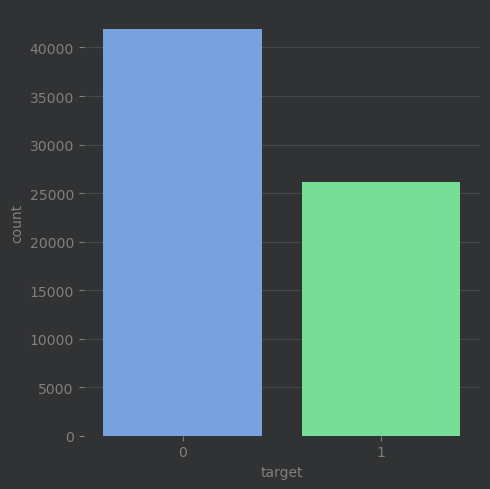

In [146]:
# Visualizando la variable target por categoría de empresa

print("\nCantidad de elementos por Clase: ")
df_cat_2 = df_info_empresas_2_1[df_info_empresas_2_1['category']=='category_2'].reset_index(drop=True)
target_count = df_cat_2['target'].value_counts()

print('Clase 0:', target_count[0], "({:.2%})".format(round(target_count[0] / (target_count[0]+target_count[1]), 2)))
print('Clase 1:', target_count[1], "({:.2%})".format(round(target_count[1] / (target_count[0]+target_count[1]), 2)))
print('Total  :', df_cat_2.shape[0])

sns.factorplot('target', data = df_cat_2, kind = 'count');
plt.show()

In [147]:
# Asigno un 10% de datos de reserva y evaluar el modelo en datos nuevos
df_2 = df_cat_2.sample(frac=0.9, random_state=1000)
df_unseen = df_cat_2.drop(df_2.index)
df_2.reset_index(inplace=True, drop=True)
df_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(df_2.shape))
print('Unseen Data For Predictions: ' + str(df_unseen.shape))

Data for Modeling: (61194, 1798)
Unseen Data For Predictions: (6799, 1798)


In [148]:
df_2.target.value_counts()

0    37716
1    23478
Name: target, dtype: int64

In [149]:
# limpieza básica
df_2 = df_2.drop(['ID','category','period'], axis=1)

### Modelos con la muestra completa

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [150]:
#Separación de predictoras y predicha
X = df_2.drop('target', axis=1)
y = df_2['target']

In [151]:
#Creación de muestras de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [152]:
ind_2 = pd.DataFrame(columns = ['Modelo', 'Muestra', 'Tamaño', 'Accuracy', 'Precision', 'Recall', 'F1Score'])

### Modelo XGBoost

In [49]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from xgboost import XGBClassifier
#XGBoost hyper-parameter tuning
params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'max_depth':[3,4,5,6],
    'min_child_weight':[2,3,4,5,6,7],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'early_stopping_rounds':[5,6,7,8,10],
    'base_score': [0.2, 0.5, 1]
}

xgb_gs_2 = RandomizedSearchCV(XGBClassifier(n_jobs=-1), 
                   params, 
                   n_jobs=-1, 
                   cv=KFold(n_splits=5), 
                   scoring='f1',
                   random_state=123)
xgb_gs_2.fit(X_train, y_train)

print('Best score:', xgb_gs_2.best_score_)
print('Best score:', xgb_gs_2.best_params_)

[19:08:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:08:10] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best score: 0.6710346813380397
Best score: {'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'early_stopping_rounds': 7, 'booster': 'gbtree', 'bas

In [154]:
xgb_gs_2.fit(X_train, y_train)
Y_pred= xgb_gs_2.predict(X_test)

[23:33:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:33:09] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [155]:
print("Matriz confusion: Test")
print(confusion_matrix(y_test,Y_pred))

ind_2 = ind_2.append({'Modelo' : 'XGBoost', 'Muestra' : 'Test', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_test,Y_pred), 
                  'Precision' : precision_score(y_test,Y_pred), 'Recall' : recall_score(y_test,Y_pred), 'F1Score' : f1_score(y_test,Y_pred)}, ignore_index = True)

Matriz confusion: Test
[[10329   997]
 [ 2842  4191]]


In [156]:
# Almacenamos las probabilidades
y_real = df_unseen['target']
Y_pred = xgb_gs_2.predict(df_unseen.drop(['ID','category','target','period'], axis=1))
U_pred = xgb_gs_2.predict_proba(df_unseen.drop(['ID','category','target','period'], axis=1))[:,1]
datos = np.hstack((df_unseen['ID'].values.reshape(-1,1), df_unseen['target'].values.reshape(-1,1), U_pred.reshape(-1,1)))
df_submmit = pd.DataFrame(datos, columns=['ID','real','prob'])
#df_submmit.to_csv('com_xgb.csv', index=False)

print("Matriz confusion: Unseen")
print(confusion_matrix(y_real,Y_pred))

ind_2 = ind_2.append({'Modelo' : 'XGBoost', 'Muestra' : 'Reserva', 'Tamaño': len(Y_pred), 'Accuracy' : accuracy_score(y_real,Y_pred), 
                  'Precision' : precision_score(y_real,Y_pred), 'Recall' : recall_score(y_real,Y_pred), 'F1Score' : f1_score(y_real,Y_pred)}, ignore_index = True)
ind_2

Matriz confusion: Unseen
[[3762  392]
 [1108 1537]]


,Modelo,Muestra,Tamaño,Accuracy,Precision,Recall,F1Score
0,XGBoost,Test,18359,0.790893,0.807826,0.595905,0.685869
1,XGBoost,Reserva,6799,0.779379,0.796786,0.581096,0.672059


## CATEGORY 1


Cantidad de elementos por Clase: 
Clase 0: 656282 (98.00%)
Clase 1: 12798 (2.00%)
Total  : 669080


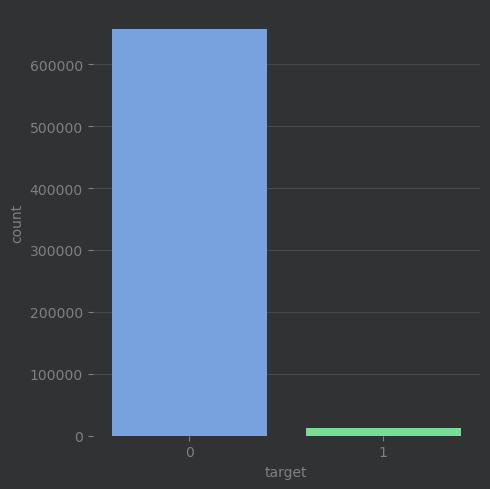

In [54]:
# Visualizando la variable target por categoría de empresa

print("\nCantidad de elementos por Clase: ")
df_cat_1 = df_info_empresas_2[df_info_empresas_2['category']=='category_1']
target_count = df_cat_1['target'].value_counts()

print('Clase 0:', target_count[0], "({:.2%})".format(round(target_count[0] / (target_count[0]+target_count[1]), 2)))
print('Clase 1:', target_count[1], "({:.2%})".format(round(target_count[1] / (target_count[0]+target_count[1]), 2)))
print('Total  :', df_cat_1.shape[0])

sns.factorplot('target', data = df_cat_1, kind = 'count');
plt.show()

In [55]:
# Asigno un 10% de datos de reserva y evaluar el modelo en datos nuevos
df_1 = df_cat_1.sample(frac=0.9, random_state=1000)
df_unseen = df_cat_1.drop(df_1.index)
df_1.reset_index(inplace=True, drop=True)
df_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(df_1.shape))
print('Unseen Data For Predictions: ' + str(df_unseen.shape))

Data for Modeling: (602172, 230)
Unseen Data For Predictions: (66908, 230)


In [56]:
# limpieza básica
df_1 = df_1.drop(['ID','category','period'], axis=1)

#### Modelos con Resampling

In [57]:
# Conteo de clases
count_class_0, count_class_1 = df_1.target.value_counts()

In [58]:
# Dividiendo los sets por clases
df_class_0 = df_1[df_1['target'] == 0]
df_class_1 = df_1[df_1['target'] == 1]

In [59]:
print('Dimensión por tipo de clases:')
print('dim class_0:',df_class_0.shape)
print('dim class_1:',df_class_1.shape)

Dimensión por tipo de clases:
dim class_0: (590689, 227)
dim class_1: (11483, 227)


#### 1. Random under-sampling (Submuestreo aleatorio)

In [60]:
df_class_0_under = df_class_0.sample(count_class_1*4)
df_under = pd.concat([df_class_0_under, df_class_1], axis=0)

In [61]:
print('Random under-sampling:')
print(df_under.target.value_counts())

Random under-sampling:
0    45932
1    11483
Name: target, dtype: int64


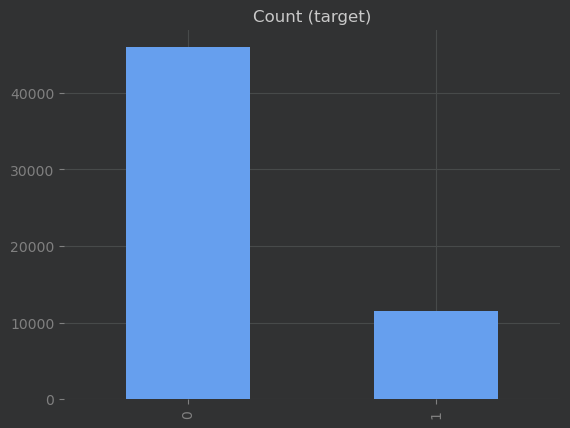

In [62]:
df_under.target.value_counts().plot(kind='bar', title='Count (target)');
plt.show()

In [63]:
#Separación de predictoras y predicha
X_1 = df_under.drop('target', axis=1)
y_1 = df_under['target']

In [64]:
#Creación de muestras de train y test
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3, random_state=22)

In [65]:
ind_1 = pd.DataFrame(columns = ['Modelo', 'Muestra', 'Tamaño', 'Accuracy', 'Precision', 'Recall', 'F1Score'])

### Modelo XGBoost

In [66]:
#XGBoost hyper-parameter tuning
params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'max_depth':[3,4,5,6],
    'min_child_weight':[2,3,4,5,6,7],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'early_stopping_rounds':[5,6,7,8,10],
    'base_score': [0.2, 0.5, 1]
}

xgb_gs_1 = RandomizedSearchCV(XGBClassifier(n_jobs=-1), 
                   params, 
                   n_jobs=-1, 
                   cv=KFold(n_splits=5), 
                   scoring='f1',
                   random_state=123)
xgb_gs_1.fit(X_train_1, y_train_1)

print('Best score:', xgb_gs_1.best_score_)
print('Best score:', xgb_gs_1.best_params_)

[19:29:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:29:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best score: 0.6879217356786619
Best score: {'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 300, 'min_child_weight': 6, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.5, 'early_stopping_rounds': 8, 'booster': 'gbtree', 'b

In [72]:
xgb_gs_1.fit(X_train_1, y_train_1)
Y_pred_1= xgb_gs_1.predict(X_test_1)

[19:54:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:54:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [73]:
print("Matriz confusion: Test")
print(confusion_matrix(y_test_1,Y_pred_1))

ind_1 = ind_1.append({'Modelo' : 'XGBoost Under', 'Muestra' : 'Test', 'Tamaño': len(Y_pred_1), 'Accuracy' : accuracy_score(y_test_1,Y_pred_1), 
                  'Precision' : precision_score(y_test_1,Y_pred_1), 'Recall' : recall_score(y_test_1,Y_pred_1), 'F1Score' : f1_score(y_test_1,Y_pred_1)}, ignore_index = True)

Matriz confusion: Test
[[13201   592]
 [ 1367  2065]]


In [75]:
# Almacenamos las probabilidades
y_real_1 = df_unseen['target']
Y_pred_1 = xgb_gs_1.predict(df_unseen.drop(['ID','category','target','period'], axis=1))
U_pred_1 = xgb_gs_1.predict_proba(df_unseen.drop(['ID','category','target','period'], axis=1))[:,1]
datos_1 = np.hstack((df_unseen['ID'].values.reshape(-1,1), df_unseen['target'].values.reshape(-1,1), U_pred_1.reshape(-1,1)))
df_submmit_1 = pd.DataFrame(datos_1, columns=['ID','real','prob'])
#df_submmit.to_csv('com_tree.csv', index=False)

print("Matriz confusion: Unseen")
print(confusion_matrix(y_real_1,Y_pred_1))

ind_1 = ind_1.append({'Modelo' : 'XGBoost Under', 'Muestra' : 'Reserva', 'Tamaño': len(Y_pred_1), 'Accuracy' : accuracy_score(y_real_1,Y_pred_1), 
                  'Precision' : precision_score(y_real_1,Y_pred_1), 'Recall' : recall_score(y_real_1,Y_pred_1), 'F1Score' : f1_score(y_real_1,Y_pred_1)}, ignore_index = True)
ind_1

Matriz confusion: Unseen
[[62729  2864]
 [  497   818]]


,Modelo,Muestra,Tamaño,Accuracy,Precision,Recall,F1Score
0,XGBoost Under,Test,17225,0.886270,0.777192,0.601690,0.678272
1,XGBoost Under,Reserva,66908,0.949767,0.222162,0.622053,0.327396


### Random over-sampling (Sobremuestreo aleatorio)

In [76]:
df_class_1_over = df_class_1.sample(round(count_class_0/4), replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

In [77]:
print('Dimensión por tipo de clases generadas:')
print('dim df_class_1_over:',df_class_1_over.shape)
print('dim df_over:',df_over.shape)

Dimensión por tipo de clases generadas:
dim df_class_1_over: (147672, 227)
dim df_over: (738361, 227)


In [78]:
print('Random over-sampling:')
print(df_over.target.value_counts())

Random over-sampling:
0    590689
1    147672
Name: target, dtype: int64


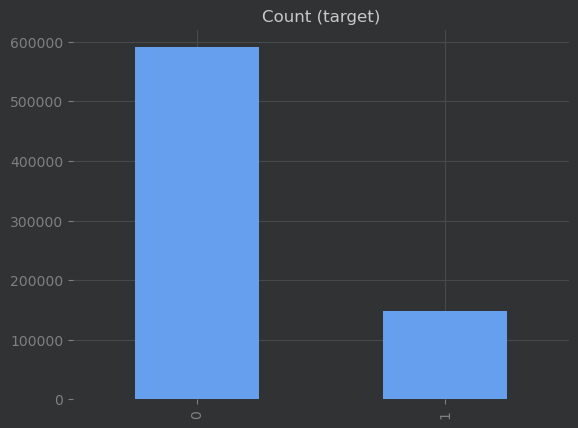

In [79]:
df_over.target.value_counts().plot(kind='bar', title='Count (target)');
plt.show()

In [80]:
#Separación de predictoras y predicha
X_1 = df_over.drop('target', axis=1)
y_1 = df_over['target']

In [81]:
#Creación de muestras de train y test
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3, random_state=22)

### Modelo XGBoost

In [82]:
#XGBoost hyper-parameter tuning
params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'max_depth':[3,4,5,6],
    'min_child_weight':[2,3,4,5,6,7],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'early_stopping_rounds':[5,6,7,8,10],
    'base_score': [0.2, 0.5, 1]
}

xgb_gs_1_os = RandomizedSearchCV(XGBClassifier(n_jobs=-1), 
                   params, 
                   n_jobs=-1, 
                   cv=KFold(n_splits=5), 
                   scoring='f1',
                   random_state=123)
xgb_gs_1_os.fit(X_train_1, y_train_1)

print('Best score:', xgb_gs_1_os.best_score_)
print('Best score:', xgb_gs_1_os.best_params_)

[20:20:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:20:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best score: 0.7279222532800779
Best score: {'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'early_stopping_rounds': 7, 'booster': 'gbtree', 'bas

In [83]:
xgb_gs_1_os.fit(X_train_1, y_train_1)
Y_pred_1= xgb_gs_1_os.predict(X_test_1)

[20:54:47] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:54:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [96]:
xgb_mod_1_os=xgb.XGBClassifier()
xgb_mod_1_os.fit(X_train_1, y_train_1)
Y_pred_1= xgb_mod_1_os.predict(X_test_1)

[21:42:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [84]:
print("Matriz confusion: Test")
print(confusion_matrix(y_test_1,Y_pred_1))

ind_1 = ind_1.append({'Modelo' : 'XGBoost Over', 'Muestra' : 'Test', 'Tamaño': len(Y_pred_1), 'Accuracy' : accuracy_score(y_test_1,Y_pred_1), 
                  'Precision' : precision_score(y_test_1,Y_pred_1), 'Recall' : recall_score(y_test_1,Y_pred_1), 'F1Score' : f1_score(y_test_1,Y_pred_1)}, ignore_index = True)

Matriz confusion: Test
[[170323   6912]
 [ 15081  29193]]


In [85]:
# Almacenamos las probabilidades
y_real_1 = df_unseen['target']
Y_pred_1 = xgb_gs_1_os.predict(df_unseen.drop(['ID','category','target','period'], axis=1))
U_pred_1 = xgb_gs_1_os.predict_proba(df_unseen.drop(['ID','category','target','period'], axis=1))[:,1]
datos_1 = np.hstack((df_unseen['ID'].values.reshape(-1,1), df_unseen['target'].values.reshape(-1,1), U_pred_1.reshape(-1,1)))
df_submmit_1 = pd.DataFrame(datos_1, columns=['ID','real','prob'])
#df_submmit.to_csv('com_tree.csv', index=False)

print("Matriz confusion: Unseen")
print(confusion_matrix(y_real_1,Y_pred_1))

ind_1 = ind_1.append({'Modelo' : 'XGBoost Over', 'Muestra' : 'Reserva', 'Tamaño': len(Y_pred_1), 'Accuracy' : accuracy_score(y_real_1,Y_pred_1), 
                  'Precision' : precision_score(y_real_1,Y_pred_1), 'Recall' : recall_score(y_real_1,Y_pred_1), 'F1Score' : f1_score(y_real_1,Y_pred_1)}, ignore_index = True)
ind_1

Matriz confusion: Unseen
[[63075  2518]
 [  503   812]]


,Modelo,Muestra,Tamaño,Accuracy,Precision,Recall,F1Score
0,XGBoost Under,Test,17225,0.886270,0.777192,0.601690,0.678272
1,XGBoost Under,Reserva,66908,0.949767,0.222162,0.622053,0.327396
2,XGBoost Over,Test,221509,0.900713,0.808558,0.659371,0.726384
3,XGBoost Over,Reserva,66908,0.954848,0.243844,0.617490,0.349623


### Advanced Resampling - SMOTE

In [66]:
!pip install imblearn

In [86]:
from imblearn.over_sampling import SMOTE

In [87]:
#Separación de predictoras y predicha
X_1 = df_1.drop('target', axis=1)
y_1 = df_1['target']

In [88]:
#Aplicando SMOTE
smote = SMOTE(sampling_strategy=0.2)
X_sm, y_sm = smote.fit_resample(X_1, y_1)

In [89]:
df_X_sm_1 = pd.DataFrame(data=X_sm,columns=X_1.columns)
df_y_sm_1 = pd.DataFrame(data=y_sm,columns=["target"])

# Concatenamos la información
df_balanceado_sm_1 = pd.concat([df_X_sm_1, df_y_sm_1], axis=1)

In [90]:
df_balanceado_sm_1.target.value_counts()

0    590689
1    118137
Name: target, dtype: int64

In [91]:
#Separación de predictoras y predicha
X_1 = df_balanceado_sm_1.drop('target', axis=1)
y_1 = df_balanceado_sm_1['target']

In [92]:
#Creación de muestras de train y test
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3, random_state=22)

### Modelo XGBoost

In [93]:
#XGBoost hyper-parameter tuning
params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'max_depth':[3,4,5,6],
    'min_child_weight':[2,3,4,5,6,7],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'early_stopping_rounds':[5,6,7,8,10],
    'base_score': [0.2, 0.5, 1]
}

xgb_gs_1_smote = RandomizedSearchCV(XGBClassifier(n_jobs=-1), 
                   params, 
                   n_jobs=-1, 
                   cv=KFold(n_splits=5), 
                   scoring='f1',
                   random_state=123)
xgb_gs_1_smote.fit(X_train_1, y_train_1)

print('Best score:', xgb_gs_1_smote.best_score_)
print('Best score:', xgb_gs_1_smote.best_params_)

[21:29:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:29:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best score: 0.8207462098356535
Best score: {'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'early_stopping_rounds': 7, 'booster': 'gbtree', 'bas

In [94]:
xgb_gs_1_smote.fit(X_train_1, y_train_1)
Y_pred_1= xgb_gs_1_smote.predict(X_test_1)

[21:56:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:56:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [95]:
print("Matriz confusion: Test")
print(confusion_matrix(y_test_1,Y_pred_1))

ind_1 = ind_1.append({'Modelo' : 'XGBoost SMOTE', 'Muestra' : 'Test', 'Tamaño': len(Y_pred_1), 'Accuracy' : accuracy_score(y_test_1,Y_pred_1), 
                  'Precision' : precision_score(y_test_1,Y_pred_1), 'Recall' : recall_score(y_test_1,Y_pred_1), 'F1Score' : f1_score(y_test_1,Y_pred_1)}, ignore_index = True)

Matriz confusion: Test
[[173319   3546]
 [  8271  27512]]


In [96]:
# Almacenamos las probabilidades
y_real_1 = df_unseen['target']
Y_pred_1 = xgb_gs_1_smote.predict(df_unseen.drop(['ID','category','target','period'], axis=1))
U_pred_1 = xgb_gs_1_smote.predict_proba(df_unseen.drop(['ID','category','target','period'], axis=1))[:,1]
datos_1 = np.hstack((df_unseen['ID'].values.reshape(-1,1), df_unseen['target'].values.reshape(-1,1), U_pred_1.reshape(-1,1)))
df_submmit_1 = pd.DataFrame(datos_1, columns=['ID','real','prob'])
#df_submmit.to_csv('com_tree.csv', index=False)

print("Matriz confusion: Unseen")
print(confusion_matrix(y_real_1,Y_pred_1))

ind_1 = ind_1.append({'Modelo' : 'XGBoost SMOTE', 'Muestra' : 'Reserva', 'Tamaño': len(Y_pred_1), 'Accuracy' : accuracy_score(y_real_1,Y_pred_1), 
                  'Precision' : precision_score(y_real_1,Y_pred_1), 'Recall' : recall_score(y_real_1,Y_pred_1), 'F1Score' : f1_score(y_real_1,Y_pred_1)}, ignore_index = True)
ind_1

Matriz confusion: Unseen
[[64332  1261]
 [  742   573]]


,Modelo,Muestra,Tamaño,Accuracy,Precision,Recall,F1Score
0,XGBoost Under,Test,17225,0.886270,0.777192,0.601690,0.678272
1,XGBoost Under,Reserva,66908,0.949767,0.222162,0.622053,0.327396
2,XGBoost Over,Test,221509,0.900713,0.808558,0.659371,0.726384
3,XGBoost Over,Reserva,66908,0.954848,0.243844,0.617490,0.349623
4,XGBoost SMOTE,Test,212648,0.944429,0.885827,0.768857,0.823207
5,XGBoost SMOTE,Reserva,66908,0.970063,0.312432,0.435741,0.363925


### CATEGORÍA 3


Cantidad de elementos por Clase: 
Clase 0: 72462 (99.00%)
Clase 1: 729 (1.00%)
Total  : 73191


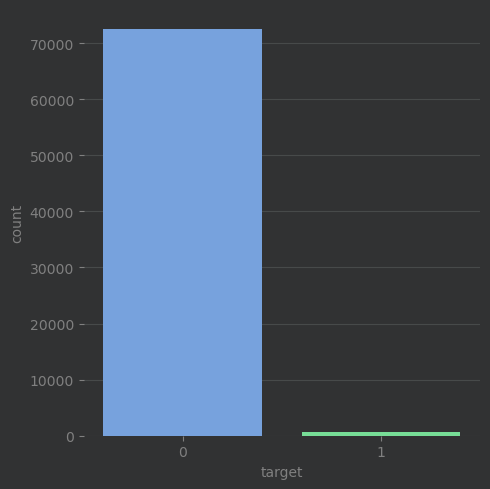

In [97]:
# Visualizando la variable target por categoría de empresa
print("\nCantidad de elementos por Clase: ")
df_cat_3 = df_info_empresas_2_1[df_info_empresas_2_1['category']=='category_3']
target_count = df_cat_3['target'].value_counts()

print('Clase 0:', target_count[0], "({:.2%})".format(round(target_count[0] / (target_count[0]+target_count[1]), 2)))
print('Clase 1:', target_count[1], "({:.2%})".format(round(target_count[1] / (target_count[0]+target_count[1]), 2)))
print('Total  :', df_cat_3.shape[0])

sns.factorplot('target', data = df_cat_3, kind = 'count');
plt.show()

In [98]:
# Asigno un 10% de datos de reserva y evaluar el modelo en datos nuevos
df_3 = df_cat_3.sample(frac=0.9, random_state=1000)
df_unseen = df_cat_3.drop(df_3.index)
df_3.reset_index(inplace=True, drop=True)
df_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(df_1.shape))
print('Unseen Data For Predictions: ' + str(df_unseen.shape))

Data for Modeling: (602172, 227)
Unseen Data For Predictions: (7319, 1798)


In [99]:
# limpieza básica
df_3 = df_3.drop(['ID','category'], axis=1)

In [100]:
# Dividiendo los sets por clases
df_class_0 = df_3[df_3['target'] == 0]
df_class_1 = df_3[df_3['target'] == 1]

In [101]:
ind_3 = pd.DataFrame(columns = ['Modelo', 'Muestra', 'Tamaño', 'Accuracy', 'Precision', 'Recall', 'F1Score'])

### 3. Advanced Resampling - SMOTE

In [102]:
#Separación de predictoras y predicha
X_1 = df_3.drop(['target','period'], axis=1)
y_1 = df_3['target']

In [103]:
#Aplicando SMOTE
smote = SMOTE(sampling_strategy=0.2)
X_sm, y_sm = smote.fit_resample(X_1, y_1)

In [104]:
df_X_sm_1 = pd.DataFrame(data=X_sm,columns=X_1.columns)
df_y_sm_1 = pd.DataFrame(data=y_sm,columns=["target"])

# Concatenamos la información
df_balanceado_sm_1 = pd.concat([df_X_sm_1, df_y_sm_1], axis=1)

In [105]:
df_balanceado_sm_1.target.value_counts()

0    65206
1    13041
Name: target, dtype: int64

In [106]:
#Separación de predictoras y predicha
X_1 = df_balanceado_sm_1.drop('target', axis=1)
y_1 = df_balanceado_sm_1['target']

In [107]:
#Creación de muestras de train y test
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3, random_state=22)

In [108]:
#XGBoost hyper-parameter tuning
params = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'max_depth':[3,4,5,6],
    'min_child_weight':[2,3,4,5,6,7],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'early_stopping_rounds':[5,6,7,8,10],
    'base_score': [0.2, 0.5, 1]
}

xgb_gs_3_smote = RandomizedSearchCV(XGBClassifier(n_jobs=-1), 
                   params, 
                   n_jobs=-1, 
                   cv=KFold(n_splits=5), 
                   scoring='f1',
                   random_state=123)
xgb_gs_3_smote.fit(X_train_1, y_train_1)

print('Best score:', xgb_gs_3_smote.best_score_)
print('Best score:', xgb_gs_3_smote.best_params_)

[22:17:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:17:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best score: 0.9475062309506793
Best score: {'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'early_stopping_rounds': 7, 'booster': 'gbtree', 'bas

In [109]:
xgb_gs_3_smote.fit(X_train_1, y_train_1)
Y_pred_1= xgb_gs_3_smote.predict(X_test_1)

[22:36:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:36:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [110]:
print("Matriz confusion: Test")
print(confusion_matrix(y_test_1,Y_pred_1))

ind_3 = ind_3.append({'Modelo' : 'XGBoost SMOTE', 'Muestra' : 'Test', 'Tamaño': len(Y_pred_1), 'Accuracy' : accuracy_score(y_test_1,Y_pred_1), 
                  'Precision' : precision_score(y_test_1,Y_pred_1), 'Recall' : recall_score(y_test_1,Y_pred_1), 'F1Score' : f1_score(y_test_1,Y_pred_1)}, ignore_index = True)

Matriz confusion: Test
[[19425    84]
 [  298  3668]]


In [111]:
# Almacenamos las probabilidades
y_real_1 = df_unseen['target']
Y_pred_1 = xgb_gs_3_smote.predict(df_unseen.drop(['ID','category','target','period'], axis=1))
U_pred_1 = xgb_gs_3_smote.predict_proba(df_unseen.drop(['ID','category','target','period'], axis=1))[:,1]
datos_1 = np.hstack((df_unseen['ID'].values.reshape(-1,1), df_unseen['target'].values.reshape(-1,1), U_pred_1.reshape(-1,1)))
df_submmit_1 = pd.DataFrame(datos_1, columns=['ID','real','prob'])
#df_submmit.to_csv('com_tree.csv', index=False)

print("Matriz confusion: Unseen")
print(confusion_matrix(y_real_1,Y_pred_1))

ind_3 = ind_3.append({'Modelo' : 'XGBoost SMOTE', 'Muestra' : 'Reserva', 'Tamaño': len(Y_pred_1), 'Accuracy' : accuracy_score(y_real_1,Y_pred_1), 
                  'Precision' : precision_score(y_real_1,Y_pred_1), 'Recall' : recall_score(y_real_1,Y_pred_1), 'F1Score' : f1_score(y_real_1,Y_pred_1)}, ignore_index = True)
ind_3

Matriz confusion: Unseen
[[7229   27]
 [  55    8]]


,Modelo,Muestra,Tamaño,Accuracy,Precision,Recall,F1Score
0,XGBoost SMOTE,Test,23475,0.983727,0.977612,0.924861,0.950505
1,XGBoost SMOTE,Reserva,7319,0.988796,0.228571,0.126984,0.163265


ALGORITMO ELEGIDO: XGBOOST SMOTE

## PREPARACIÓN PREDICCIÓN DATASET TEST

In [112]:
list_train_2_1 = list(df_info_empresas_2_1.columns)
list_test_2_1 = list(df_info_empresas_test_2_1.columns)

In [113]:
vars_quitar_test_2_1 = [x for x in list_test_2_1 if x not in list_train_2_1]

In [114]:
vars_quitar_test_2_1

['balance_amount_sum_1_entity_5_type_2_product_8',
 'balance_amount_sum_2_entity_5_type_2_product_8',
 'balance_amount_sum_3_entity_5_type_2_product_8',
 'balance_amount_sum_4_entity_5_type_2_product_8',
 'days_default_sum_1_entity_5_type_2_product_8',
 'days_default_sum_2_entity_5_type_2_product_8',
 'days_default_sum_3_entity_5_type_2_product_8',
 'days_default_sum_4_entity_5_type_2_product_8']

In [115]:
df_info_empresas_test_2_1.drop(vars_quitar_test_2_1, axis=1, inplace=True)

In [116]:
df_test_1 = df_info_empresas_test_2[df_info_empresas_test_2['category']=='category_1']
df_test_2 = df_info_empresas_test_2_1[df_info_empresas_test_2_1['category']=='category_2']
df_test_3 = df_info_empresas_test_2_1[df_info_empresas_test_2_1['category']=='category_3']

In [121]:
# Almacenamos las probabilidades
Y_pred_test1 = xgb_gs_1_smote.predict(df_test_1.drop(['ID','category','period'], axis=1))

In [122]:
datos_test1 = np.hstack((df_test_1['ID'].values.reshape(-1,1), Y_pred_test1.reshape(-1,1)))
df_submmit_1 = pd.DataFrame(datos_test1, columns=['ID','target'])

In [123]:
df_submmit_1

,ID,target
0,669c9da570306d5124c865db91a459fb245e80d39043dd...,0
1,177b7e415e558c22d6bf675567755d61bb6f8b69c671f6...,0
2,371352ffefb1695cb7aa844e0bb48009ba43f0988c9c39...,0
3,27e752493fd4534762870e1f85fc6f7e0d31e597b6c918...,0
4,6f993c79a43888e4b742fdc3a63b308f3395d990db4c75...,1
...,...,...
293764,a546d4c5cb5841342475fdaa47487e112478869949138f...,0
293765,2c44b7fde8244ad39f6bfcd4c75cd46c7dbfb140d2e896...,0
293766,ac7ea3943f3efb4495b4c74a3ac29b270a44ff8fff11f7...,0
293767,d468ef205b477344c25430819983ceaaa6e9c345fb3ab0...,0


In [135]:
# distribución
df_submmit_1['target'].value_counts() 

0    287729
1      6040
Name: target, dtype: int64

In [117]:
# Almacenamos las probabilidades
Y_pred_test2 = xgb_gs_2.predict(df_test_2.drop(['ID','category','period'], axis=1))
U_pred_test2 = xgb_gs_2.predict_proba(df_test_2.drop(['ID','category','period'], axis=1))[:,1]

In [118]:
datos_test2 = np.hstack((df_test_2['ID'].values.reshape(-1,1), Y_pred_test2.reshape(-1,1)))
df_submmit_2 = pd.DataFrame(datos_test2, columns=['ID','target'])

In [119]:
df_submmit_2

,ID,target
0,0d2728d7fabfe554a02c3f7135b2b44e2ba64802d2b7d9...,1
1,6966695b7781cf1504e9f390ad5432c556ee1d36847a03...,0
2,a49c807c546a8c43cc82b15430008153066903aee7c9f6...,1
3,397c665a1d04476f4b26d2671bfce6820006f42934f898...,0
4,c644f921fdc65b5bb1ee06f622ca0cca1339333241b233...,1
...,...,...
19464,6f1b2af0083d29c04191819a643422aba5091442a45a4b...,0
19465,22be9306fa447489090cc7158e2e46ffe2cbd315e03567...,1
19466,dfc1664d62ece14581d660c0b3a46570bc6efd6032acb6...,1
19467,5da377ba108a5fa5dcdaac7b9b2c2d4498774abd9d53d4...,0


In [134]:
# distribución
df_submmit_2['target'].value_counts()

0    9942
1    9527
Name: target, dtype: int64

In [125]:
# Almacenamos las probabilidades
Y_pred_test3 = xgb_gs_3_smote.predict(df_test_3.drop(['ID','category','period'], axis=1))
U_pred_test3 = xgb_gs_3_smote.predict_proba(df_test_3.drop(['ID','category','period'], axis=1))[:,1]

In [126]:
datos_test3 = np.hstack((df_test_3['ID'].values.reshape(-1,1), Y_pred_test3.reshape(-1,1)))
df_submmit_3 = pd.DataFrame(datos_test3, columns=['ID','target'])

In [127]:
df_submmit_3

,ID,target
0,a52ae46810459cc4f18f849f821f4b6a14f9140123ec17...,0
1,513311f66c33938375bade6e42aaadaff0052ba18ad64d...,0
2,1ad9bed858db1a7caa0a6ee5e117ef30d731eee7a04c40...,0
3,3ec619a0e7b5d44744d9791ed80b6725729867bcafaa10...,0
4,eae1720aa87f4b46f07ee48b637ea8ee78ed9664972dd3...,0
...,...,...
15968,483332dfd1d1ddbf0a43f819a280da697730284cd873c4...,0
15969,c449274add30f09ce7bd6788605bc6be329782f8f75b86...,0
15970,e3c9a2f7ca96445bbd74e3d49ce4bee9f8884e1517b639...,0
15971,bbe20638ee9fd89adfc5c43e1fdf243507f61b584312b0...,0


In [133]:
# distribución
df_submmit_3['target'].value_counts()

0    15887
1       86
Name: target, dtype: int64

In [129]:
df_submmit = pd.concat([df_submmit_1,df_submmit_2,df_submmit_3], axis=0).reset_index(drop='index')

In [130]:
df_submmit

,ID,target
0,669c9da570306d5124c865db91a459fb245e80d39043dd...,0
1,177b7e415e558c22d6bf675567755d61bb6f8b69c671f6...,0
2,371352ffefb1695cb7aa844e0bb48009ba43f0988c9c39...,0
3,27e752493fd4534762870e1f85fc6f7e0d31e597b6c918...,0
4,6f993c79a43888e4b742fdc3a63b308f3395d990db4c75...,1
...,...,...
329206,483332dfd1d1ddbf0a43f819a280da697730284cd873c4...,0
329207,c449274add30f09ce7bd6788605bc6be329782f8f75b86...,0
329208,e3c9a2f7ca96445bbd74e3d49ce4bee9f8884e1517b639...,0
329209,bbe20638ee9fd89adfc5c43e1fdf243507f61b584312b0...,0


In [131]:
df_submmit.to_csv('output/submit_4_asct.csv')

In [132]:
df_submmit['target'].value_counts()

0    313558
1     15653
Name: target, dtype: int64

### Producción de modelos entrenados

In [158]:
# Guardo modelos en un archivo
import pickle
pickle.dump(xgb_gs_1_smote, open("output/model_cat_1.pickle.dat", "wb"))
pickle.dump(xgb_gs_2, open("output/model_cat_2.pickle.dat", "wb"))
pickle.dump(xgb_gs_3_smote, open("output/model_cat_3.pickle.dat", "wb"))

In [159]:
# Carga de modelos desde el archivo
model_cat_1 = pickle.load(open("output/model_cat_1.pickle.dat", "rb"))
model_cat_2 = pickle.load(open("output/model_cat_2.pickle.dat", "rb"))
model_cat_3 = pickle.load(open("output/model_cat_3.pickle.dat", "rb"))

In [163]:
import pickle

In [164]:
# Versiones librerias
%watermark --iversions

xgboost   : 1.5.0
matplotlib: 3.5.2
seaborn   : 0.11.2
numpy     : 1.21.5
pandas    : 1.4.4

